Purpose: Develop code to either a) upsample all stressors in train set to the level of the stressor with maximum samples, or b) downsample likewise. Do this for just the stressed samples, then up/downsample the control samples to match.<br>
Author: Anna Pardo<br>
Date initiated: July 12, 2023

In [12]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# import tpm data
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")

In [5]:
# list of stressors
s = ["Drought","Salt","Heat","Low_Nitrogen","Flooding","Cold"]

In [4]:
# pull out the number of samples in each stressor
nsamp = []
for i in s:
    if i=="Drought":
        df = tpm[tpm["Treatment"].isin([i,"DroughtRepeat"])]
    else:
        df = tpm[tpm["Treatment"]==i]
    nsamp.append(len(df["Sample"].unique()))

In [5]:
nsdf = pd.DataFrame(list(zip(s,nsamp)),columns=["Stressor","N_samples"])

In [6]:
# find max or min
maxmin = "min"
if maxmin=="max":
    mmdf = nsdf[nsdf["N_samples"]==max(nsdf["N_samples"])]
elif maxmin=="min":
    mmdf = nsdf[nsdf["N_samples"]==min(nsdf["N_samples"])]

In [7]:
mstressor = mmdf.iloc[0,0]
mstressor

'Salt'

In [8]:
mnsamp = mmdf.iloc[0,1]
mnsamp

29

In [6]:
# actually I just need to drop the controls and set up 6-way labeling (0-5)
cl = []
for i in range(len(s)):
    cl.append(i)
cldf = pd.DataFrame(list(zip(s,cl)),columns=["Treatment","Class"])
cldf

,Treatment,Class
0,Drought,0
1,Salt,1
2,Heat,2
3,Low_Nitrogen,3
4,Flooding,4
5,Cold,5


In [10]:
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [7]:
# replace DroughtRepeat with Drought
tpm["Treatment"].mask(tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [8]:
tpm["Treatment"].unique()

array(['Drought', 'Control', 'Heat', 'Cold', 'Salt', 'Low_Nitrogen',
       'Flooding'], dtype=object)

In [9]:
tpmclass = cldf.merge(tpm[tpm["Treatment"]!="Control"],how="right")

In [10]:
# drop BioProject and Treatment, set Sample as index, and split X and y
# when a Label column is present (binary control/stress labeling) that will need to be dropped as well
tpmclass = tpmclass.drop(["BioProject","Treatment"],axis=1)
tpmclass = tpmclass.set_index("Sample")
tpmclass.head()

,Class,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.00000,1.122904,...,0.171184,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000
SRR11933272,0,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.00000,2.280915,...,0.108052,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000
SRR11933250,0,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.00000,1.908468,...,0.000000,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349
SRR11933040,0,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.00000,2.264390,...,0.178304,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959
SRR11932822,0,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.34758,2.147482,...,0.131348,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105


In [11]:
X = tpmclass.drop("Class",axis=1)
y = tpmclass["Class"]

In [16]:
# try upsampling!
sm = SMOTE(random_state=42)
Xup, yup = sm.fit_resample(X,y)

In [17]:
from collections import Counter

In [18]:
counter = Counter(y)

In [19]:
counter_up = Counter(yup)

In [20]:
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=608 (51.833%)
Class=2, n=187 (15.942%)
Class=5, n=225 (19.182%)
Class=1, n=29 (2.472%)
Class=3, n=76 (6.479%)
Class=4, n=48 (4.092%)


In [21]:
for k,v in counter_up.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=608 (51.833%)
Class=2, n=608 (51.833%)
Class=5, n=608 (51.833%)
Class=1, n=608 (51.833%)
Class=3, n=608 (51.833%)
Class=4, n=608 (51.833%)


In [22]:
# extract the control samples from the original TPM matrix
cont = tpm[tpm["Treatment"]=="Control"]
cont.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.370075
7,SRR11933230,PRJNA637522,Control,30.677016,24.648455,0.000000,22.170584,5.274585,0.570215,0.185118,...,0.000000,0.000000,0.0,0.090086,0.219642,0.000000,0.0,0.0,0.0,1.140361
9,SRR11933475,PRJNA637522,Control,15.222661,3.913437,0.334832,13.907885,1.810991,8.406630,0.070472,...,0.000000,0.031179,0.0,0.000000,0.000000,0.598329,0.0,0.0,0.0,1.788829
11,SRR11932901,PRJNA637522,Control,4.295425,1.882124,0.000000,3.027463,1.859511,8.323136,0.000000,...,0.030638,0.037595,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.751058
14,SRR11932833,PRJNA637522,Control,7.621540,3.790581,0.000000,10.273807,2.100084,3.191459,0.208129,...,0.150049,0.000000,0.0,0.000000,0.000000,8.604951,0.0,0.0,0.0,1.050432


In [23]:
yup

0       0
1       0
2       0
3       0
4       0
       ..
3643    5
3644    5
3645    5
3646    5
3647    5
Name: Class, Length: 3648, dtype: int64

In [24]:
# re-combine X and y for the upsampled data
Xup.reset_index().merge(yup.reset_index())

,index,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Class
0,0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.000000,1.122904,...,0.000000,0.0,0.000000,0.00000,0.309501,0.0,0.000000,0.0,0.000000,0
1,1,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.000000,2.280915,...,0.127878,0.0,0.000000,0.00000,6.703281,0.0,0.000000,0.0,0.000000,0
2,2,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.000000,1.908468,...,0.000000,0.0,0.000000,0.00000,0.417565,0.0,0.254123,0.0,1.213349,0
3,3,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.000000,2.264390,...,0.012158,0.0,0.000000,0.00000,9.625225,0.0,0.000000,0.0,2.352959,0
4,4,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.347580,2.147482,...,0.000000,0.0,0.287114,0.00000,0.000000,0.0,0.000000,0.0,1.604105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,3643,18.517356,3.237580,1.459225,15.451643,0.046229,6.712040,0.250542,0.000000,0.136367,...,0.147582,0.0,0.035385,0.00000,3.399188,0.0,0.000000,0.0,0.000000,5
3644,3644,1.232061,174.796090,0.000000,21.327369,0.140559,4.479665,0.058234,1.388922,0.000000,...,7.939784,0.0,0.000000,0.00000,0.786274,0.0,0.000000,0.0,0.869770,5
3645,3645,3.238880,1.049523,0.000000,3.871371,0.039231,8.053676,0.103746,0.000000,0.191795,...,0.091245,0.0,0.029771,0.39564,0.000000,0.0,0.000000,0.0,0.000000,5
3646,3646,8.205529,289.701861,0.040866,63.716415,0.146268,126.633225,0.244027,2.347086,0.000000,...,6.163895,0.0,0.000000,0.00000,0.000000,0.0,0.380512,0.0,0.000000,5


In [25]:
tpmclass.reset_index()

,Sample,Class,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.00000,...,0.171184,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,0,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.00000,...,0.108052,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,0,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933040,0,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.00000,...,0.178304,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959
4,SRR11932822,0,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.34758,...,0.131348,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,CML228D1D,0,1.427602,0.000000,0.000000,0.000000,0.000000,1.614686,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1169,CML333D3D,0,9.580153,0.000000,0.000000,0.000000,1.018369,5.386801,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1170,P39D3D,0,4.286976,0.781353,0.000000,0.000000,0.000000,0.149383,0.000000,0.00000,...,0.000000,0.165622,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1171,M162WD3D,0,3.435711,0.379497,0.000000,0.000000,1.660372,1.889381,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [26]:
upsamp = pd.concat([yup,Xup],axis=1)

In [27]:
upsamp.head()

,Class,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.00000,1.122904,...,0.171184,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,0,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.00000,2.280915,...,0.108052,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,0,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.00000,1.908468,...,0.000000,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,0,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.00000,2.264390,...,0.178304,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959
4,0,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.34758,2.147482,...,0.131348,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105


In [28]:
upsamp["Label"] = 1
upsamp.head()

/tmp/ipykernel_154/2686887467.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  upsamp["Label"] = 1


,Class,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.00000,1.122904,...,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,0,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.00000,2.280915,...,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,0,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.00000,1.908468,...,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
3,0,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.00000,2.264390,...,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959,1
4,0,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.34758,2.147482,...,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105,1


In [29]:
cont["Label"] = 0
cont.head()

/tmp/ipykernel_154/391608163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont["Label"] = 0


,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.370075,0
7,SRR11933230,PRJNA637522,Control,30.677016,24.648455,0.000000,22.170584,5.274585,0.570215,0.185118,...,0.000000,0.0,0.090086,0.219642,0.000000,0.0,0.0,0.0,1.140361,0
9,SRR11933475,PRJNA637522,Control,15.222661,3.913437,0.334832,13.907885,1.810991,8.406630,0.070472,...,0.031179,0.0,0.000000,0.000000,0.598329,0.0,0.0,0.0,1.788829,0
11,SRR11932901,PRJNA637522,Control,4.295425,1.882124,0.000000,3.027463,1.859511,8.323136,0.000000,...,0.037595,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.751058,0
14,SRR11932833,PRJNA637522,Control,7.621540,3.790581,0.000000,10.273807,2.100084,3.191459,0.208129,...,0.000000,0.0,0.000000,0.000000,8.604951,0.0,0.0,0.0,1.050432,0


In [30]:
# drop Class from stressed samples, drop Sample, BioProject, Treatment from control samples
upsamp = upsamp.drop("Class",axis=1)
cont = cont.drop(["Sample","BioProject","Treatment"],axis=1)

In [31]:
upsamp.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.00000,1.122904,0.0,...,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.00000,2.280915,0.0,...,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.00000,1.908468,0.0,...,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
3,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.00000,2.264390,0.0,...,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959,1
4,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,1.34758,2.147482,0.0,...,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105,1


In [32]:
cont.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
3,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,0.0,1.619452,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.370075,0
7,30.677016,24.648455,0.000000,22.170584,5.274585,0.570215,0.185118,0.0,4.128655,0.000000,...,0.000000,0.0,0.090086,0.219642,0.000000,0.0,0.0,0.0,1.140361,0
9,15.222661,3.913437,0.334832,13.907885,1.810991,8.406630,0.070472,0.0,0.634416,0.000000,...,0.031179,0.0,0.000000,0.000000,0.598329,0.0,0.0,0.0,1.788829,0
11,4.295425,1.882124,0.000000,3.027463,1.859511,8.323136,0.000000,0.0,0.337491,0.000000,...,0.037595,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.751058,0
14,7.621540,3.790581,0.000000,10.273807,2.100084,3.191459,0.208129,0.0,0.000000,0.433673,...,0.000000,0.0,0.000000,0.000000,8.604951,0.0,0.0,0.0,1.050432,0


In [34]:
# append cont to upsamp
alldf = pd.concat([upsamp,cont],axis=0)
len(alldf.index) == len(upsamp.index)+len(cont.index)

True

In [ ]:
# at this point the df can now be fed into control vs. stressed up/downsampling

Next objective: figure out code for multiclass downsampling.

In [35]:
mstressor

'Salt'

In [36]:
mnsamp

29

<AxesSubplot: >

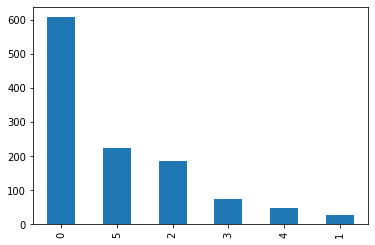

In [13]:
# back to tpm: plot the value counts
count = y.value_counts()
count.plot.bar()

In [14]:
# solution from https://towardsdatascience.com/how-to-deal-with-imbalanced-multiclass-datasets-in-python-fe0bb3f2b669
## set the median as a threshold above which downsampling will be conducted and below which oversampling will be conducted
n_samples = count.median().astype(np.int64)

In [15]:
# define sampling strategy function
def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

In [16]:
# downsample majority classes
from imblearn.under_sampling import ClusterCentroids
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X,y,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X, y)

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
# upsampling minority classes
over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

In [18]:
# try counting again
count_bal = y_bal.value_counts()

<AxesSubplot: >

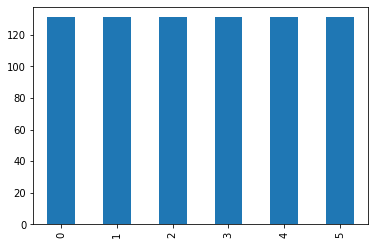

In [19]:
count_bal.plot.bar()

In [20]:
# put together a function for median sampling

def median_sample(X,y):
    count = y.value_counts()
    n_samples = count.median().astype(np.int64)
    
    # downsample majority classes
    under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X,y,n_samples,t='majority'))
    X_under, y_under = under_sampler.fit_resample(X, y)
    
    # upsample minority classes
    over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
    X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)
    
    return X_bal,y_bal

In [21]:
# put together an omnibus function for up/downsampling
def resample(train,sampling):
    """
    Args:
        train = TPM dataframe with columns for Sample, Treatment, BioProject, and Label (training set only!)
        sampling = "up" or "median" (note, should be lowercase)
    """
    # replace DroughtRepeat with Drought in TPM matrix (if extant)
    if "DroughtRepeat" in train["Treatment"].unique():
        train["Treatment"].mask(train["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    
    # drop control samples
    traintreat = train[train["Treatment"]!="Control"]
    # pull out control samples and save for later
    cont = train[train["Treatment"]=="Control"]
    
    # generate list of stressors in dataframe
    stressors = list(traintreat["Treatment"].unique())
    
    # set up 5-way class labeling
    cl = []
    for i in range(len(stressors)):
        cl.append(i)
    cldf = pd.DataFrame(list(zip(stressors,cl)),columns=["Treatment","Class"])
    
    # merge with traintreat
    ttclass = cldf.merge(traintreat,how="right")
    
    # drop BioProject & Treatment
    ttclass = ttclass.drop(["BioProject","Treatment"],axis=1)
    # set Sample as index
    ttclass = ttclass.set_index("Sample")
    # split into X and y
    X = ttclass.drop("Class",axis=1)
    y = ttclass["Class"]
    
    if sampling=="up":
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X,y)
    elif sampling=="median":
        X_res, y_res = median_sample(X,y)
        
    # stick X and y back together
    upsamp = pd.concat([y_res,X_res],axis=1)
    # set a Label column
    upsamp["Label"] = 1
    # drop the Class column
    upsamp = upsamp.drop("Class",axis=1)
    
    # drop Sample, BioProject, and Treatment from control data
    cont = cont.drop(["Sample","BioProject","Treatment"],axis=1)
    # set Label column for controls
    cont["Label"] = 0
    
    # append cont to upsamp
    alldf = pd.concat([upsamp,cont],axis=0)
    
    # split into X and y again
    X_all = alldf.drop("Label",axis=1)
    y_all = alldf["Label"]
    # upsample the controls to match the stressed samples
    sm2 = SMOTE(random_state=42)
    X_all_res,y_all_res = sm2.fit_resample(X_all,y_all)
    
    return X_all_res,y_all_res